### Conducting basic NLP on sentence and segment level text

In [1]:
SEED = 0

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

PATH_SENTENCE_TEXT = r"../dataset/concat_sentence_text.csv"

In [18]:
def visualise_results_heatmap(clf_report) :
    return sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot = True)

In [2]:
class GloveVectorizer:
    def __init__(self, verbose=False, lowercase=True, remove_stopwords = True, minchars=3):
        
        # load in pre-trained word vectors
        print('Loading word vectors...')
        word2vec = {}
        embedding = []
        idx2word = []
        with open('../glove/glove.6B/glove.6B.50d.txt', encoding = "utf-8") as f:
              # is just a space-separated text file in the format:
              # word vec[0] vec[1] vec[2] ...
              for line in f:
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
                embedding.append(vec)
                idx2word.append(word)
        print('Found %s word vectors.' % len(word2vec))

        self.word2vec = word2vec
        self.embedding = np.array(embedding)
        self.word2idx = {v:k for k,v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape
        self.verbose = verbose
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.minchars = minchars

    def fit(self, data, *args):
        pass

    def transform(self, data, *args):
        stopwords = list(text.ENGLISH_STOP_WORDS)
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0

        for sentence in data:
            # Note: lower-casing the words
            if self.lowercase & self.remove_stopwords:
                tokens = sentence.lower().split()
                tokens = [word for word in tokens if word not in stopwords]

            else:
                tokens = sentence.split()
                tokens = [word for word in tokens if word not in stopwords]
            vecs = []
            for word in tokens:
                if len(word) >= self.minchars and word in self.word2vec:
                    vec = self.word2vec[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        if self.verbose:
            print("Number of samples with no words found / total: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, X, *args):
        self.fit(X, *args)
        return self.transform(X, *args)

In [3]:
gv = GloveVectorizer()

Loading word vectors...
Found 400000 word vectors.


## Part 1: NLP on sentence level text

In [4]:
df = pd.read_csv(PATH_SENTENCE_TEXT)
df.head()

,sentence_text,practice,modality
0,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
1,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_IP_Address_1stParty,PERFORMED
2,"IP addresses will be collected, along with inf...",Identifier_IP_Address_1stParty,PERFORMED
3,The information that our products collect incl...,Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
4,The information that our products collect incl...,Identifier_IP_Address_1stParty,PERFORMED


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18829 entries, 0 to 18828
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentence_text  18829 non-null  object
 1   practice       18829 non-null  object
 2   modality       18829 non-null  object
dtypes: object(3)
memory usage: 441.4+ KB


In [6]:
df["sentence_text"] = df["sentence_text"].astype("string")
df["practice"] = df["practice"].astype("string")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18829 entries, 0 to 18828
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentence_text  18829 non-null  string
 1   practice       18829 non-null  string
 2   modality       18829 non-null  object
dtypes: object(1), string(2)
memory usage: 441.4+ KB


In [8]:
# Save counts into a dataframe
df_value_counts = df["practice"].value_counts().rename_axis("practice").reset_index(name = "counts")
df_value_counts.head(10)

,practice,counts
0,Identifier_Cookie_or_similar_Tech_1stParty,2107
1,Contact_E_Mail_Address_1stParty,2106
2,Location_1stParty,1514
3,Identifier_Cookie_or_similar_Tech_3rdParty,1250
4,Identifier_IP_Address_1stParty,1005
5,Contact_Phone_Number_1stParty,970
6,Identifier_Device_ID_1stParty,697
7,Contact_Postal_Address_1stParty,597
8,SSO,504
9,Demographic_Age_1stParty,428


In [9]:
## Limit to top 5 categories
top_5_cats = list(df_value_counts["practice"][:5])

df = df[df["practice"].isin(top_5_cats)]
df.head()

,sentence_text,practice,modality
0,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
1,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_IP_Address_1stParty,PERFORMED
2,"IP addresses will be collected, along with inf...",Identifier_IP_Address_1stParty,PERFORMED
3,The information that our products collect incl...,Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
4,The information that our products collect incl...,Identifier_IP_Address_1stParty,PERFORMED


In [10]:
vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,4), strip_accents='ascii', binary = True)
tfidf_vectors = vectorizer.fit_transform(df["sentence_text"])

In [11]:
# Vectorizer for glove
glove_vectors = gv.fit_transform(df["sentence_text"])

In [12]:
# Sanity check: Number of rows in matrix same as number of sentences.
# We have 51747 unique tokens after tokenisation
print(len(df))
print(tfidf_vectors.shape)

7982
(7982, 218540)


In [13]:
# Train test split, 20% test size?
x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df["practice"], test_size = 0.2, random_state = SEED)

x_train_gv, x_test_gv, y_train_gv, y_test_gv = train_test_split(glove_vectors, df["practice"], test_size = 0.2, random_state = SEED)

In [14]:
# Binarize labels to plot OVR ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = "Identifier_Cookie_or_similar_Tech_1stParty"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

In [15]:
def classification_report_with_cv(model, X, y, cv=5):
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs = -1)
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    return {
        'accuracy': acc,
        'macro_avg': macro_avg,
        'weighted_avg': weighted_avg,
        'report': report
    }

## Testing with logistic regression + tfidf

In [16]:
logistic_clf = LogisticRegression(random_state = 1, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
y_pred = logistic_clf.predict(x_test)
y_score = logistic_clf.predict_proba(x_test)

In [19]:
result = classification_report_with_cv(logistic_clf, tfidf_vectors, df["practice"])
print('Accuracy:', result['accuracy'])
print('Macro avg:', result['macro_avg'])
print('Weighted avg:', result['weighted_avg'])

Accuracy: 0.6390628915058882
Macro avg: {'precision': 0.6480032699448783, 'recall': 0.5828993405216792, 'f1-score': 0.5917296004983694, 'support': 7982}
Weighted avg: {'precision': 0.6448168048547648, 'recall': 0.6390628915058882, 'f1-score': 0.6204884544224042, 'support': 7982}


<AxesSubplot:>

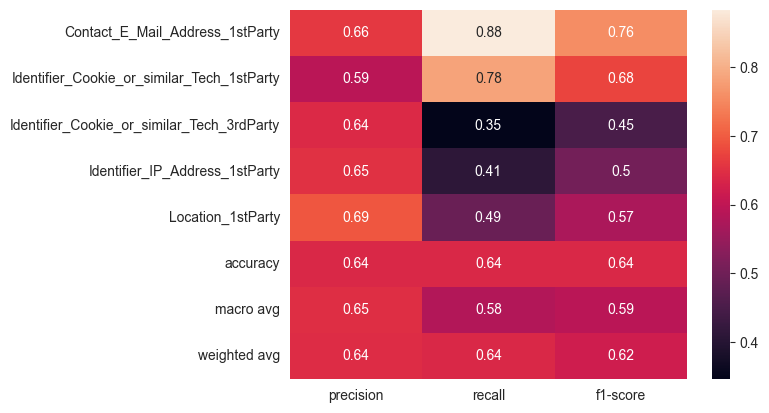

In [20]:
visualise_results_heatmap(result['report'])

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def plot_multiclass_roc(clf, X, y, n_folds=5):
    """
    Plots a multiclass ROC curve using stratified k-fold cross-validation.
    
    Parameters:
    clf (classifier object): A classifier object that implements the 'fit' and 'predict_proba' methods.
    X (array-like): The feature matrix.
    y (array-like): The label vector.
    n_folds (int): The number of folds for stratified k-fold cross-validation.
    
    Returns:
    None.
    """
    skf = StratifiedKFold(n_splits=n_folds)
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    lw = 2
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Perform k-fold cross-validation
    for i, (train, test) in enumerate(skf.split(X, y)):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and ROC area for each class
        for j in range(len(colors)):
            fpr[j], tpr[j], _ = roc_curve(y[test], probas_[:, j], pos_label=j)
            roc_auc[j] = auc(fpr[j], tpr[j])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y[test].ravel(), probas_.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot ROC curve
        plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4)
        for j, color in zip(range(len(colors)), colors):
            plt.plot(fpr[j], tpr[j], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(j, roc_auc[j]))
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    
    # Plot labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC curve with 5-fold cross-validation')
    plt.legend(loc="lower right")
    plt.show()


In [31]:
plot_multiclass_roc(logistic_clf, tfidf_vectors, df["practice"].values)

c:\Users\Tristan\Desktop\Capstone ML and Data privacy\capstone-repo\capstone\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
c:\Users\Tristan\Desktop\Capstone ML and Data privacy\capstone-repo\capstone\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
c:\Users\Tristan\Desktop\Capstone ML and Data privacy\capstone-repo\capstone\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
c:\Users\Tristan\Desktop\Capstone ML and Data privacy\capstone-repo\capstone\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricW

ValueError: multiclass format is not supported

<Figure size 1200x800 with 0 Axes>

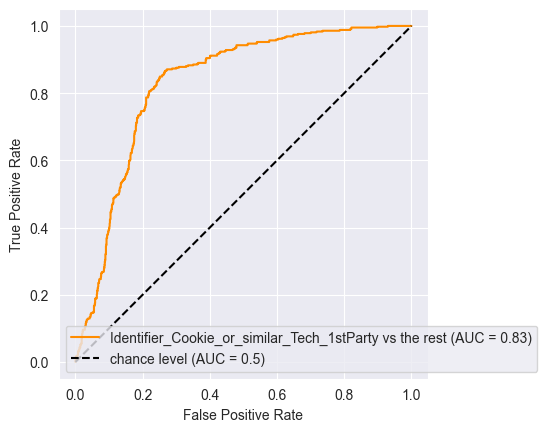

In [53]:
plt.figure(figsize=(12,8))

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Logistic regression + glove

In [32]:
logistic_clf = LogisticRegression(random_state = 1, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train_gv, y_train_gv)
# y_pred = logistic_clf.predict(x_test_gv)
# y_score = logistic_clf.predict_proba(x_test_gv)

In [33]:
result = classification_report_with_cv(logistic_clf, glove_vectors, df["practice"])
print('Accuracy:', result['accuracy'])
print('Macro avg:', result['macro_avg'])
print('Weighted avg:', result['weighted_avg'])

Accuracy: 0.5538712102230018
Macro avg: {'precision': 0.5304609741443433, 'recall': 0.49767952832467455, 'f1-score': 0.49871903129529116, 'support': 7982}
Weighted avg: {'precision': 0.5423051854100548, 'recall': 0.5538712102230018, 'f1-score': 0.5356381147255186, 'support': 7982}


<AxesSubplot:>

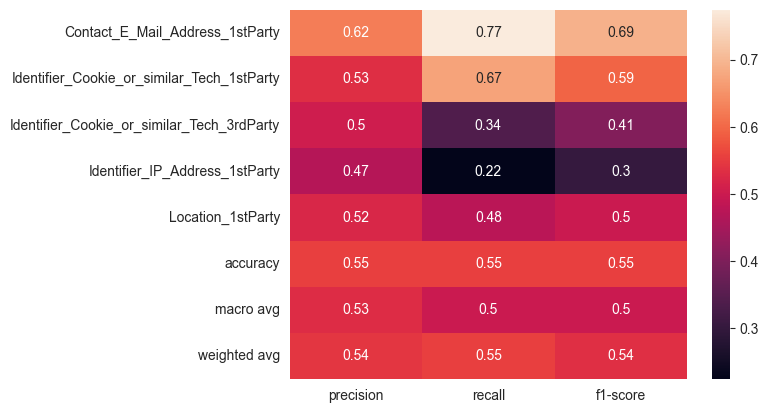

In [34]:
visualise_results_heatmap(result["report"])

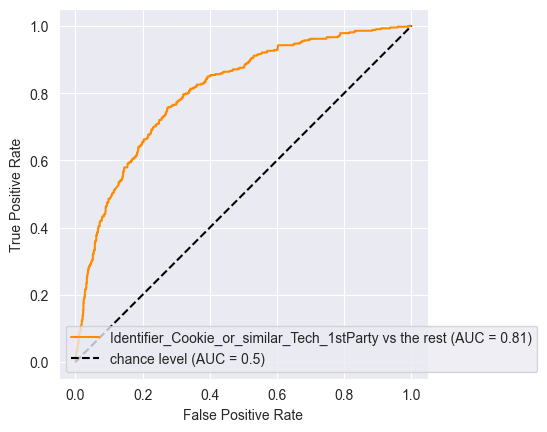

In [56]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Testing with SGDClassifier

In [22]:
clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state = 1, n_jobs = -1).fit(x_train, y_train)
y_pred = clf_sgdclassifier.predict(x_test)

In [23]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.71      0.81      0.76       417
Identifier_Cookie_or_similar_Tech_1stParty       0.57      0.62      0.59       425
Identifier_Cookie_or_similar_Tech_3rdParty       0.47      0.39      0.42       246
            Identifier_IP_Address_1stParty       0.51      0.41      0.46       212
                         Location_1stParty       0.56      0.56      0.56       297

                                  accuracy                           0.59      1597
                                 macro avg       0.57      0.56      0.56      1597
                              weighted avg       0.58      0.59      0.59      1597



In [24]:
scores = cross_val_score(clf_sgdclassifier, tfidf_vectors, df["practice"], scoring = "f1_weighted", cv = 5, n_jobs = -1, verbose = 2)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


0.6501718666474117


## Testing with LinearSVC (used by the original authors)

With tfidf

In [35]:
linearSVC_clf = SVC(kernel= "linear", class_weight="balanced", probability=True).fit(x_train, y_train)
# y_pred = linearSVC_clf.predict(x_test)
# y_score = linearSVC_clf.predict_proba(x_test)

In [36]:
result = classification_report_with_cv(linearSVC_clf, tfidf_vectors, df["practice"])
print('Accuracy:', result['accuracy'])
print('Macro avg:', result['macro_avg'])
print('Weighted avg:', result['weighted_avg'])

Accuracy: 0.6633675770483588
Macro avg: {'precision': 0.6457668383768065, 'recall': 0.642396580659081, 'f1-score': 0.6428428149220742, 'support': 7982}
Weighted avg: {'precision': 0.6609139794160095, 'recall': 0.6633675770483588, 'f1-score': 0.6608465682934873, 'support': 7982}


In [37]:
result["report"]

{'Contact_E_Mail_Address_1stParty': {'precision': 0.7379310344827587,
  'recall': 0.8129154795821463,
  'f1-score': 0.7736104835065523,
  'support': 2106},
 'Identifier_Cookie_or_similar_Tech_1stParty': {'precision': 0.6736990154711674,
  'recall': 0.6820123398196488,
  'f1-score': 0.6778301886792453,
  'support': 2107},
 'Identifier_Cookie_or_similar_Tech_3rdParty': {'precision': 0.5888704318936877,
  'recall': 0.5672,
  'f1-score': 0.5778321108394459,
  'support': 1250},
 'Identifier_IP_Address_1stParty': {'precision': 0.5774783445620789,
  'recall': 0.5970149253731343,
  'f1-score': 0.5870841487279843,
  'support': 1005},
 'Location_1stParty': {'precision': 0.6508553654743391,
  'recall': 0.5528401585204755,
  'f1-score': 0.5978571428571429,
  'support': 1514},
 'accuracy': 0.6633675770483588,
 'macro avg': {'precision': 0.6457668383768065,
  'recall': 0.642396580659081,
  'f1-score': 0.6428428149220742,
  'support': 7982},
 'weighted avg': {'precision': 0.6609139794160095,
  'recal

<AxesSubplot:>

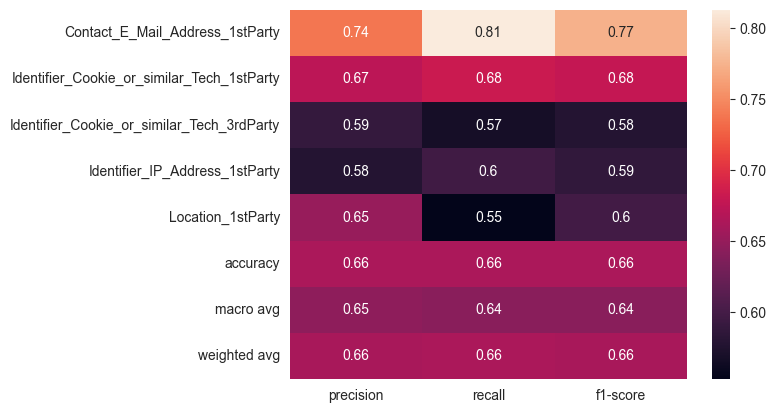

In [38]:
visualise_results_heatmap(result["report"])

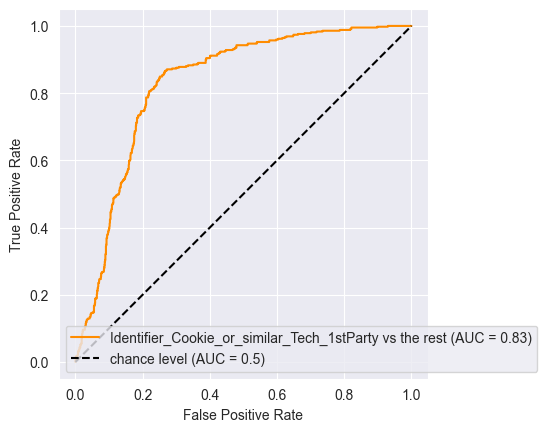

In [48]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### SVC with glove

In [43]:
linearSVC_clf = SVC(kernel= "linear", class_weight="balanced", probability=True).fit(x_train_gv, y_train_gv)
# y_pred = linearSVC_clf.predict(x_test_gv)
# y_score = linearSVC_clf.predict_proba(x_test_gv)

In [41]:
result = classification_report_with_cv(linearSVC_clf, glove_vectors, df["practice"])
print('Accuracy:', result['accuracy'])
print('Macro avg:', result['macro_avg'])
print('Weighted avg:', result['weighted_avg'])

Accuracy: 0.5472312703583062
Macro avg: {'precision': 0.5265386331682133, 'recall': 0.533085303370919, 'f1-score': 0.5268173123358083, 'support': 7982}
Weighted avg: {'precision': 0.557489279320991, 'recall': 0.5472312703583062, 'f1-score': 0.549787246781635, 'support': 7982}


In [45]:
result["report"]

{'Contact_E_Mail_Address_1stParty': {'precision': 0.7000946073793756,
  'recall': 0.7027540360873694,
  'f1-score': 0.7014218009478673,
  'support': 2106},
 'Identifier_Cookie_or_similar_Tech_1stParty': {'precision': 0.6073654390934844,
  'recall': 0.5087802562885619,
  'f1-score': 0.5537190082644627,
  'support': 2107},
 'Identifier_Cookie_or_similar_Tech_3rdParty': {'precision': 0.45997088791848617,
  'recall': 0.5056,
  'f1-score': 0.4817073170731707,
  'support': 1250},
 'Identifier_IP_Address_1stParty': {'precision': 0.3717277486910995,
  'recall': 0.4945273631840796,
  'f1-score': 0.4244235695986336,
  'support': 1005},
 'Location_1stParty': {'precision': 0.49353448275862066,
  'recall': 0.4537648612945839,
  'f1-score': 0.47281486579490706,
  'support': 1514},
 'accuracy': 0.5472312703583062,
 'macro avg': {'precision': 0.5265386331682133,
  'recall': 0.533085303370919,
  'f1-score': 0.5268173123358083,
  'support': 7982},
 'weighted avg': {'precision': 0.557489279320991,
  'rec

<AxesSubplot:>

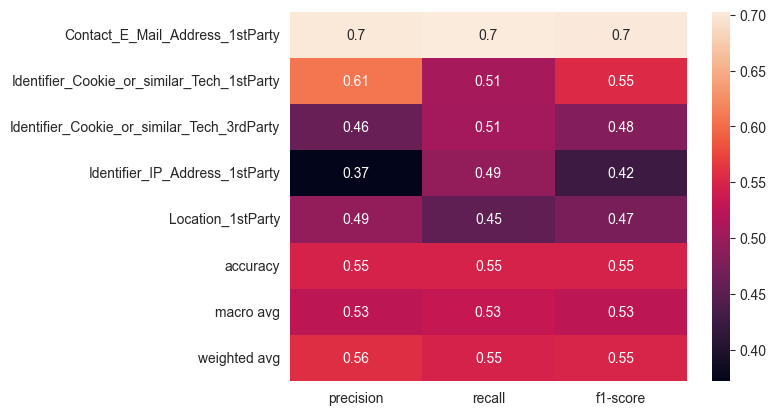

In [42]:
visualise_results_heatmap(result["report"])

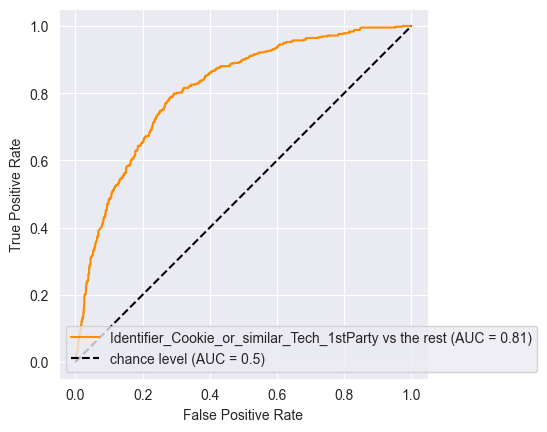

In [59]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Random forests

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
# clf_randomforest = RandomForestClassifier(n_jobs = -1, random_state = SEED).fit(x_train, y_train)
# y_pred = clf_randomforest.predict(x_test)

In [27]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.65      0.75      0.70       413
Identifier_Cookie_or_similar_Tech_1stParty       0.48      0.57      0.52       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.37      0.30      0.33       238
            Identifier_IP_Address_1stParty       0.44      0.34      0.38       214
                         Location_1stParty       0.52      0.44      0.48       314

                                  accuracy                           0.52      1597
                                 macro avg       0.49      0.48      0.48      1597
                              weighted avg       0.51      0.52      0.51      1597



### Summary (29/8/22): Trying different models using Tfidf yields low performance. 
The issue should be with feature engineering. Need to look at word embeddings first perhaps, before looking at what models to use.

TODO: How does this affect interpret package usage?

### Summary (3/9/22): Tried BERT both on all categories and on top 5 categories. Both yield low performance. 
Might be because not enough training data to train all the parameters.

Non-neural networks yield better performance out of the box. 
So stick to linear models, but at the same time figure out to limit to which categories to predict? 

### Boosting classifiers

In [32]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#### AdaBoost default (uses decision tree as base classifier)
Tried with SVC, took too long to train and results were very poor.

Decision tree classifiers seem to take very long to train on the dataset. About 8m? As seen below

In [33]:
clf_ada_boost = AdaBoostClassifier(DecisionTreeClassifier(), random_state=SEED).fit(x_train, y_train)
y_pred = clf_ada_boost.predict(x_test)

In [34]:
print(classification_report(y_test, y_pred))

'                                            precision    recall  f1-score   support\n\n           Contact_E_Mail_Address_1stParty       0.59      0.71      0.65       413\nIdentifier_Cookie_or_similar_Tech_1stParty       0.45      0.47      0.46       418\nIdentifier_Cookie_or_similar_Tech_3rdParty       0.31      0.30      0.31       238\n            Identifier_IP_Address_1stParty       0.42      0.29      0.34       214\n                         Location_1stParty       0.48      0.44      0.46       314\n\n                                  accuracy                           0.48      1597\n                                 macro avg       0.45      0.44      0.44      1597\n                              weighted avg       0.47      0.48      0.47      1597\n'

#### AdaBoost with logistic regression as base classifier

In [37]:
clf_ada_boost = AdaBoostClassifier(LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr"), random_state=SEED, n_estimators=200).fit(x_train, y_train)
y_pred = clf_ada_boost.predict(x_test)

In [38]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.61      0.76      0.68       413
Identifier_Cookie_or_similar_Tech_1stParty       0.37      0.97      0.54       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.00      0.00      0.00       238
            Identifier_IP_Address_1stParty       1.00      0.01      0.02       214
                         Location_1stParty       1.00      0.01      0.01       314

                                  accuracy                           0.45      1597
                                 macro avg       0.60      0.35      0.25      1597
                              weighted avg       0.59      0.45      0.32      1597



c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [44]:
classification_report(y_test, y_pred, output_dict=True)

c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

{'Contact_E_Mail_Address_1stParty': {'precision': 0.6140350877192983,
  'recall': 0.7627118644067796,
  'f1-score': 0.6803455723542118,
  'support': 413},
 'Identifier_Cookie_or_similar_Tech_1stParty': {'precision': 0.37407407407407406,
  'recall': 0.9665071770334929,
  'f1-score': 0.5393858477970627,
  'support': 418},
 'Identifier_Cookie_or_similar_Tech_3rdParty': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 238},
 'Identifier_IP_Address_1stParty': {'precision': 1.0,
  'recall': 0.009345794392523364,
  'f1-score': 0.018518518518518517,
  'support': 214},
 'Location_1stParty': {'precision': 1.0,
  'recall': 0.006369426751592357,
  'f1-score': 0.012658227848101266,
  'support': 314},
 'accuracy': 0.45272385723231057,
 'macro avg': {'precision': 0.5976218323586744,
  'recall': 0.34898685251687767,
  'f1-score': 0.2501816333035789,
  'support': 1597},
 'weighted avg': {'precision': 0.5873258949223752,
  'recall': 0.45272385723231057,
  'f1-score': 0.322093708371151

### Testing performance with the top n practices (from top 3 - 8)
Using logistic regression, SGDClassifier, linearSVC, paired with Tf-IDF.

LinearSVC seems to give the most balanced performance (i.e in the sense of recall and precision) across the top N categories.

In [8]:
def testing_top_n() :
    
    results_dict = {"N" : [], "clf" : [], "report" : []}

    for n in range(3, 11) :

        print("Training for " + str(n))
        # iterate through the top n practices
        top_n_practice = list(df_value_counts["practice"][:n])
        df_subset = df[df["practice"].isin(top_n_practice)]
        
        # Vectorize and split training and test sets
        vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,4), strip_accents='ascii', binary = True)
        tfidf_vectors = vectorizer.fit_transform(df_subset["sentence_text"])
        x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df_subset["practice"], test_size = 0.2, random_state = SEED)
        
        # Fit classifiers
        print("Fitting logistic...")
        logistic_clf = LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
        y_pred = logistic_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [logistic_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SGDClassifier...")
        clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state=SEED, n_jobs = -1).fit(x_train, y_train)
        y_pred = clf_sgdclassifier.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [clf_sgdclassifier]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SVC...")
        linearSVC_clf = SVC(kernel= "linear", class_weight="balanced").fit(x_train, y_train)
        y_pred = linearSVC_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [linearSVC_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Training done " + str(n))

    return results_dict
        

In [9]:
df = pd.read_csv(PATH_SENTENCE_TEXT)

# Save counts into a dataframe
df_value_counts = df["practice"].value_counts().rename_axis("practice").reset_index(name = "counts")
df_value_counts.head(10)

,practice,counts
0,Identifier_Cookie_or_similar_Tech_1stParty,2107
1,Contact_E_Mail_Address_1stParty,2106
2,Location_1stParty,1514
3,Identifier_Cookie_or_similar_Tech_3rdParty,1250
4,Identifier_IP_Address_1stParty,1005
5,Contact_Phone_Number_1stParty,970
6,Identifier_Device_ID_1stParty,697
7,Contact_Postal_Address_1stParty,597
8,SSO,504
9,Demographic_Age_1stParty,428


In [10]:
results_dict = testing_top_n()

Training for 3
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 3
Training for 4
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 4
Training for 5
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 5
Training for 6
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 6
Training for 7
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 7
Training for 8
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 8
Training for 9
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 9
Training for 10
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 10


In [11]:
df_results = pd.DataFrame(results_dict)

df_results.head()

,N,clf,report
0,3,"LogisticRegression(max_iter=500, multi_class='...",{'Contact_E_Mail_Address_1stParty': {'precisio...
1,3,"SGDClassifier(max_iter=5000, n_jobs=-1, random...",{'Contact_E_Mail_Address_1stParty': {'precisio...
2,3,"SVC(class_weight='balanced', kernel='linear')",{'Contact_E_Mail_Address_1stParty': {'precisio...
3,4,"LogisticRegression(max_iter=500, multi_class='...",{'Contact_E_Mail_Address_1stParty': {'precisio...
4,4,"SGDClassifier(max_iter=5000, n_jobs=-1, random...",{'Contact_E_Mail_Address_1stParty': {'precisio...


<AxesSubplot:>

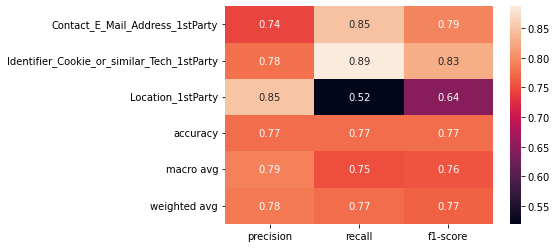

In [31]:
# Where N = 3, logistic regression
visualise_results(df_results.loc[df_results["N"] == 3]["report"].iloc[0])

<AxesSubplot:>

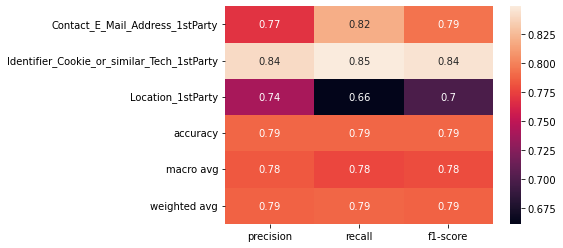

In [34]:
# Where N = 3, SVC
visualise_results(df_results.loc[df_results["N"] == 3]["report"].iloc[2])

<AxesSubplot:>

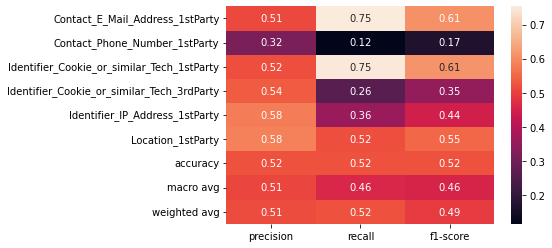

In [33]:
# Where N = 6, logistic regression
visualise_results(df_results.loc[df_results["N"] == 6]["report"].iloc[0])

<AxesSubplot:>

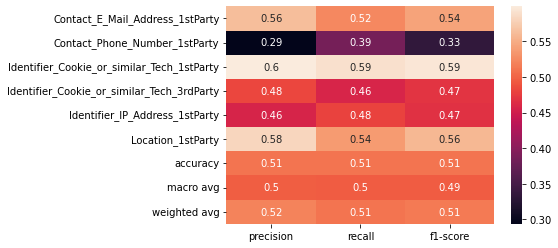

In [37]:
# Where N = 6, SVC
visualise_results(df_results.loc[df_results["N"] == 6]["report"].iloc[2])

<AxesSubplot:>

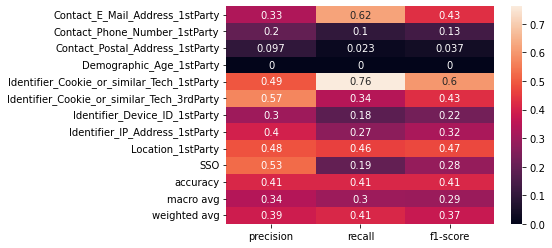

In [32]:
# Where N = 10, logistic regression
visualise_results(df_results.loc[df_results["N"] == 10]["report"].iloc[0])

<AxesSubplot:>

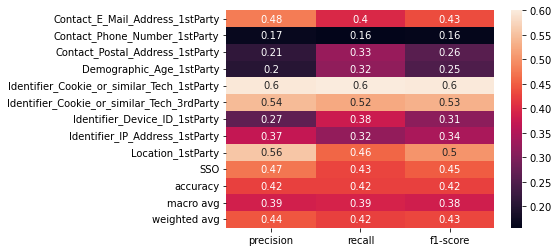

In [36]:
# Where N = 10, SVC
visualise_results(df_results.loc[df_results["N"] == 10]["report"].iloc[2])

### Visualise by grouped barchart, 
By weighted avg, as we have different support across the different classes

In [12]:
weighted_avg_dict = {"precision" : [], "recall" : [], "f1" : [], "support" : []}

for row in df_results.itertuples(index = False) :
    weighted_avg_dict["precision"] += [row[2]["weighted avg"]["precision"]]
    weighted_avg_dict["recall"] += [row[2]["weighted avg"]["recall"]]
    weighted_avg_dict["f1"] += [row[2]["weighted avg"]["f1-score"]]
    weighted_avg_dict["support"] += [row[2]["weighted avg"]["support"]]

In [13]:
df_results_weighted_avg = pd.DataFrame(
    {"N" : df_results["N"],
    "classifier" : ["logistic", "sgd", "svc"] * 8,
    "precision" : weighted_avg_dict["precision"],
    "recall" : weighted_avg_dict["recall"],
    "f1" : weighted_avg_dict["f1"],
    "support" : weighted_avg_dict["support"]}
)

df_results_weighted_avg.head()

,N,classifier,precision,recall,f1,support
0,3,logistic,0.784020,0.774869,0.766348,1146
1,3,sgd,0.778056,0.777487,0.774011,1146
2,3,svc,0.786877,0.787958,0.786539,1146
3,4,logistic,0.693727,0.690544,0.680007,1396
4,4,sgd,0.657406,0.658309,0.656638,1396


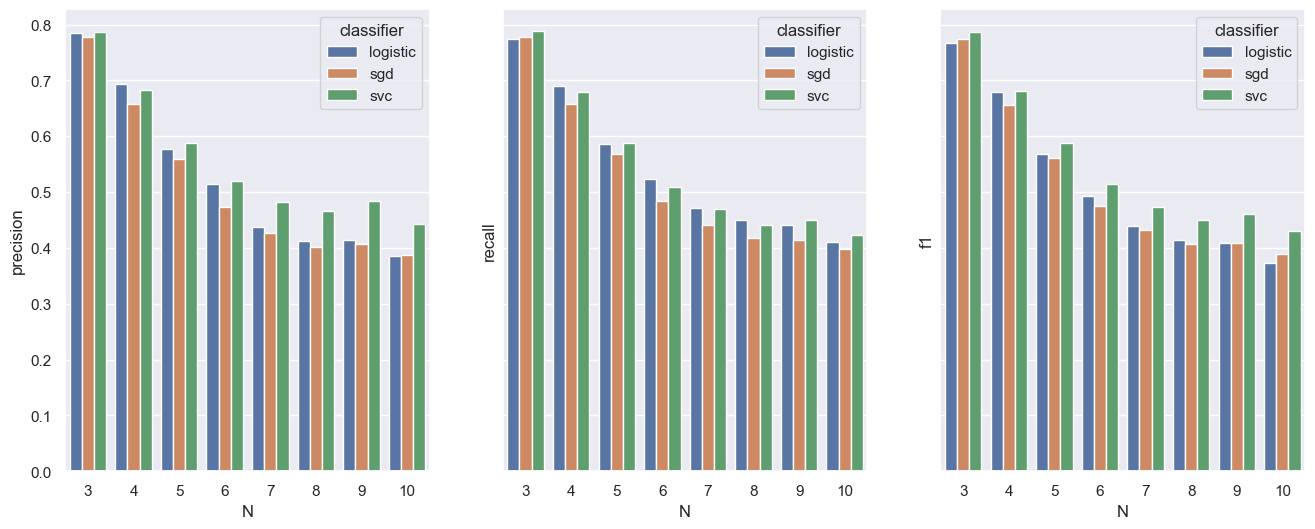

In [33]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
sns.set(rc={'figure.figsize':(16,6)})

sns.barplot(data = df_results_weighted_avg, x = "N", y = "precision", hue = "classifier", ax = ax[0])
sns.barplot(data = df_results_weighted_avg, x = "N", y = "recall", hue = "classifier", ax = ax[1])
sns.barplot(data = df_results_weighted_avg, x = "N", y = "f1", hue = "classifier", ax=ax[2])

plt.show()